In [13]:
import os
import pandas as pd
import json
import numpy as np

def load_electricity_data(folder_path):
    electricity_data = []
    for file in os.listdir(folder_path):
        if file.endswith(".json"):
            with open(os.path.join(folder_path, file), 'r') as f:
                try:
                    data = json.load(f)["response"]["data"]
                    electricity_data.extend(data)
                except KeyError:
                    print(f"Skipping file {file} due to unexpected format")
    electricity_df = pd.DataFrame(electricity_data)
    electricity_df["period"] = pd.to_datetime(electricity_df["period"], errors='coerce')
    electricity_df["value"] = electricity_df["value"].astype(str).str.extract(r'([0-9]+\.?[0-9]*)')[0]
    electricity_df["value"] = pd.to_numeric(electricity_df["value"], errors='coerce')
    electricity_df = electricity_df.rename(columns={"period": "datetime", "value": "demand_mwh"})
    electricity_df["datetime"] = pd.to_datetime(electricity_df["datetime"], errors='coerce', utc=True)
    return electricity_df.dropna()

def load_weather_data(folder_path):
    weather_data = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))
            df.rename(columns=lambda x: x.strip(), inplace=True)
            df["date"] = pd.to_datetime(df["date"], errors='coerce', utc=True)
            weather_data.append(df)
    weather_df = pd.concat(weather_data, ignore_index=True)
    weather_df = weather_df.rename(columns={"date": "datetime", "temperature_2m": "temperature"})
    weather_df["datetime"] = pd.to_datetime(weather_df["datetime"], errors='coerce', utc=True)
    return weather_df.dropna()
 
def merge_data(folder_path = "raw"):
    electricity_folder = os.path.join(folder_path, "electricity_raw_data")
    weather_folder = os.path.join(folder_path, "weather_raw_data")

    # Load data
    electricity_df = load_electricity_data(electricity_folder)
    weather_df = load_weather_data(weather_folder)
    
    # Merge data
    data = pd.merge(electricity_df, weather_df, on="datetime", how="inner")
    data["demand_mwh"] = pd.to_numeric(data["demand_mwh"], errors='coerce')
    data.sort_values(by="datetime", inplace=True)
    
    return data


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def feature_engineering(data):
    
    # Feature Engineering
    data["hour"] = data["datetime"].dt.hour
    data["day"] = data["datetime"].dt.day
    data["month"] = data["datetime"].dt.month
    data['year'] = data["datetime"].dt.year
    data["day_of_week"] = data["datetime"].dt.dayofweek
    data["is_weekend"] = data["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
    data["season"] = data["month"].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')
    data = pd.get_dummies(data, columns=['season'], drop_first=True)

    return data

def data_type_conversions(data):
    
    # Ensure demand_mwh is numeric
    data["demand_mwh"] = pd.to_numeric(data["demand_mwh"], errors='coerce')

    # Sort data by datetime
    data.sort_values(by="datetime", inplace=True)

    return data

def test_mcar(df):
    df_miss = df.isnull().astype(int)
    chi2, p, _, _ = chi2_contingency(df_miss.corr())
    return p  # If p > 0.05, data is MCAR

def data_cleaning_and_consistency(df):
    # 1. Identify missing values per column
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # 2. Display missing values summary
    missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
    print("Missing Values Summary:")
    print(missing_summary[missing_summary['Missing Values'] > 0])
    
    p_value = test_mcar(df)
    if p_value > 0.05:
        print("Missing data is likely MCAR (Missing Completely at Random)")
    else:
        print("Missing data is likely MAR (Missing at Random) or MNAR (Not Missing at Random)")

    # 5. Handling missing data
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':  # Categorical columns
                df[col].fillna(df[col].mode()[0], inplace=True)  # Impute with mode
            else:  # Numerical columns
                df[col].fillna(df[col].median(), inplace=True)  # Impute with median

    print("Missing values handled using mode (categorical) or median (numerical)")

    return df

def handle_duplicates_and_anomalies(df):
    # Remove duplicate rows
    df = df.drop_duplicates()

    # Identify numerical columns
    num_cols = df.select_dtypes(include=['number']).columns

    # Detect outliers using IQR method
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Mark outliers
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        print(f"Outliers detected in {col}: {outliers.sum()} rows")

        # df = df[~outliers]

    return df

def normalize_data(data):
    # Identify numerical columns for normalization/standardization
    num_cols = data.select_dtypes(include=['number']).columns

    # Choose either StandardScaler (Z-score normalization) or MinMaxScaler (scales to [0,1])
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
    return data

def process_data(df):

    df = data_type_conversions(df)
    df = data_cleaning_and_consistency(df)
    df = handle_duplicates_and_anomalies(df)
    df = feature_engineering(df)

    return df

In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def statistical_summary(df):
    """
    Computes statistical metrics for each numerical variable in the dataframe and returns
    a prettified DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with numerical variables
    
    Returns:
    pd.DataFrame: A DataFrame containing the statistical summaries
    """
    # Select numerical columns
    num_cols = df.select_dtypes(include=['number']).columns

    if len(num_cols) == 0:
        return "No numerical columns found in the DataFrame."

    # Dictionary to store summaries for each variable
    summary_dict = {}

    for col in num_cols:
        summary_dict[col] = {
            "Mean": df[col].mean(),
            "Median": df[col].median(),
            "Standard Deviation": df[col].std(),
            "Variance": df[col].var(),
            "Skewness": df[col].skew(),
            "Kurtosis": stats.kurtosis(df[col], fisher=True),
            "Min": df[col].min(),
            "Max": df[col].max(),
            "25th Percentile": df[col].quantile(0.25),
            "50th Percentile (Median)": df[col].quantile(0.50),
            "75th Percentile": df[col].quantile(0.75)
        }

    # Convert dictionary to DataFrame for pretty display
    summary_df = pd.DataFrame(summary_dict).T

    return summary_df

def plot_time_series(df, datetime_col="datetime", demand_col="demand_mwh", sample_rate=1000):
    """
    Plots a clean time series line chart without unwanted fill effects.

    :param df: Pandas DataFrame containing time series data
    :param datetime_col: Column name representing timestamps
    :param demand_col: Column name representing electricity demand
    :param sample_rate: Interval to downsample data for better visualization
    """
    # Convert datetime column to proper format
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Sort data by time
    df = df.sort_values(by=datetime_col)

    # Downsample data (optional but improves clarity)
    # df_sampled = df.iloc[::sample_rate]  # Pick every nth row
    df_sampled = df

    # Set figure size
    plt.figure(figsize=(14, 6))

    # Plot as a thin line (no fill)
    plt.plot(df_sampled[datetime_col], df_sampled[demand_col], color='blue', linewidth=1, linestyle='-')

    # Titles and labels
    plt.title("Electricity Demand Over Time", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Electricity Demand", fontsize=12)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Grid for better visualization
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()

def univariate_analysis(df):
    """
    Perform univariate analysis: Histogram, Boxplot, Density plot.
    
    :param df: Pandas DataFrame containing the data
    :param column: Column name (numerical feature) to analyze
    """

    # Convert datetime column to actual datetime format
    df["datetime"] = pd.to_datetime(df["datetime"])

    # Selecting only numerical columns
    numerical_cols = df.select_dtypes(include=["number"]).columns

    # Iterate over each numerical column
    for col in numerical_cols:
        plt.figure(figsize=(18, 5))

        # Histogram
        plt.subplot(1, 3, 1)
        sns.histplot(df[col], bins=30, kde=True, color='blue')
        plt.title(f"Histogram of {col}")

        # Boxplot
        plt.subplot(1, 3, 2)
        sns.boxplot(y=df[col], color='green')
        plt.title(f"Boxplot of {col}")

        # Density Plot
        plt.subplot(1, 3, 3)
        sns.kdeplot(df[col], fill=True, color='red')
        plt.title(f"Density Plot of {col}")

        plt.show()

        # Statistical Summary
        stats = df[col].describe()
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()

        print(f"\n🔹 Statistical Summary for {col}:\n")
        print(stats)
        print(f"Skewness: {skewness}")
        print(f"Kurtosis: {kurtosis}\n")
        print("-" * 50)

def correlation_analysis(df, threshold=0.75):
    """
    Computes and visualizes the correlation matrix for numerical features.
    Identifies multicollinearity issues by flagging highly correlated features.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    threshold (float): Correlation threshold for identifying multicollinearity (default = 0.75)

    Returns:
    high_corr_pairs (list): List of highly correlated feature pairs
    """
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Compute correlation matrix
    corr_matrix = df[numerical_cols].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

    # Identifying Multicollinearity (correlation > threshold)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Print highly correlated features
    if high_corr_pairs:
        print("\n🔹 Highly Correlated Feature Pairs (|correlation| > {}):".format(threshold))
        for feature1, feature2, correlation in high_corr_pairs:
            print(f"{feature1} ↔ {feature2} | Correlation: {correlation:.2f}")
    else:
        print("\n✅ No strong multicollinearity detected (correlation > {}).".format(threshold))
    
    return high_corr_pairs

def time_series_analysis(df, date_col, target_col, period=24):
    """
    Performs time series decomposition and stationarity testing (ADF Test).

    Parameters:
    df (pd.DataFrame): Input DataFrame with time series data
    date_col (str): Column name containing datetime information
    target_col (str): Column name for the time series variable (e.g., demand)
    period (int): Seasonal period for decomposition (default = 24 for hourly data)

    Returns:
    None
    """
    # Convert date column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)

    # Time Series Decomposition
    decomposition = sm.tsa.seasonal_decompose(df[target_col], model='additive', period=period)

    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    decomposition.observed.plot(ax=axes[0], title="Observed")
    decomposition.trend.plot(ax=axes[1], title="Trend")
    decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
    decomposition.resid.plot(ax=axes[3], title="Residuals", linestyle='dashed')

    for ax in axes:
        ax.set_xlabel("Date")
    
    plt.tight_layout()
    plt.show()

    # Stationarity Test: Augmented Dickey-Fuller Test
    print("\n📉 Augmented Dickey-Fuller Test Results:")
    adf_test = adfuller(df[target_col].dropna())
    results = pd.Series(adf_test[:4], index=['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    print(results)

    # Interpretation
    if adf_test[1] < 0.05:
        print("\n✅ The time series is stationary (p-value < 0.05).")
    else:
        print("\n⚠️ The time series is non-stationary (p-value >= 0.05). Consider differencing or detrending.")
        
    # Reset index after analysis
    df.reset_index(inplace=True)

def perform_eda(df):
    statistical_summary_result = statistical_summary(df)
    print(statistical_summary_result)

    plot_time_series(df)

    univariate_analysis(df)

    high_corr_pairs = correlation_analysis(df)

    time_series_analysis(df, "datetime", "demand_mwh")

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers

def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(zscore(data[column]))
    return z_scores > threshold

def detect_and_handle_outliers(df, column, method="remove"):
    """
    Detects and handles outliers in the specified column of the dataset.

    Parameters:
        df (pd.DataFrame): The dataset containing the column.
        column (str): The column name to analyze.
        method (str): Strategy to handle outliers - "remove", "cap", or "transform".

    Returns:
        pd.DataFrame: The dataset after applying the outlier handling strategy.
    """

    # Handle Outliers Based on the Selected Method
    df_cleaned = df.copy()
    
    if method == "remove":
        iqr_outliers = detect_outliers_iqr(df, column)
        df_cleaned = df_cleaned[~iqr_outliers]  # Remove outliers
    elif method == "cap":
        df_cleaned[column] = np.clip(df_cleaned[column], lower_bound, upper_bound)  # Cap values
    elif method == "transform":
        df_cleaned[column] = np.log1p(df_cleaned[column])  # Log transformation

    # Plot Before and After
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].hist(df[column], bins=50, color="blue", alpha=0.7)
    axs[0].set_title(f"Original {column} Distribution")

    axs[1].hist(df_cleaned[column], bins=50, color="red", alpha=0.7)
    axs[1].set_title(f"After Applying {method.capitalize()} Method")

    plt.show()
    
    return df_cleaned

def outliers(df):

    # Apply to demand_mwh column
    iqr_outliers = detect_outliers_iqr(df, "demand_mwh")
    print("IQR Outliers (demand_mwh):", iqr_outliers.sum())
    zscore_outliers = detect_outliers_zscore(df, "demand_mwh")
    print("Z-score Outliers (demand_mwh):", zscore_outliers.sum())
    
    # Apply to temperature column
    iqr_outliers = detect_outliers_iqr(df, "temperature")
    print("IQR Outliers (temperature):", iqr_outliers.sum())
    zscore_outliers = detect_outliers_zscore(df, "temperature")
    print("Z-score Outliers (temperature):", zscore_outliers.sum())

    # Run Outlier Detection & Handling
    cleaned_data = detect_and_handle_outliers(df, "demand_mwh", method="transform")
    cleaned_data = detect_and_handle_outliers(cleaned_data, "temperature", method="remove")

    return cleaned_data


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def regression_model(df, target, time_column, test_size=0.2):
    """
    Builds and evaluates a regression model to predict electricity demand.

    Parameters:
        df (pd.DataFrame): The preprocessed dataset.
        target (str): The column name of the target variable (e.g., electricity demand).
        time_column (str): The column representing timestamps.
        test_size (float): Proportion of data used for testing (default = 0.2).

    Returns:
        model (LinearRegression): Trained regression model.
        predictions (np.array): Predictions on test data.
    """

    # Ensure time_column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])

    # Define Features (Excluding Non-Numeric Columns)
    feature_cols = ["hour", "day", "month", "year", "day_of_week", "is_weekend", "season_Spring", "season_Summer", "season_Winter"]
    if "temperature" in df.columns:
        feature_cols.append("temperature")  # Include temperature if available

    X = df[feature_cols]
    y = df[target]

    # Split into Training & Testing Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance Metrics:\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)  # Perfect fit line
    plt.xlabel("Actual Demand")
    plt.ylabel("Predicted Demand")
    plt.title("Actual vs Predicted Electricity Demand")
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=30, kde=True, color="purple")
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
    plt.xlabel("Residuals")
    plt.title("Residual Analysis")
    plt.show()

    return model, y_pred


Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Missing data is likely MAR (Missing at Random) or MNAR (Not Missing at Random)
Missing values handled using mode (categorical) or median (numerical)
Outliers detected in demand_mwh: 28496 rows
Outliers detected in temperature: 121 rows
                    Mean     Median  Standard Deviation      Variance  \
demand_mwh   1556.937606  1120.0000         1455.568629  2.118680e+06   
temperature    11.346059    10.8085            8.095719  6.554067e+01   
hour           11.502223    12.0000            6.921747  4.791058e+01   
day            15.721857    16.0000            8.807689  7.757539e+01   
month           6.517648     7.0000            3.450933  1.190894e+01   
year         2023.002887  2023.0000            0.818553  6.700293e-01   
day_of_week     2.998708     3.0000            2.001674  4.006699e+00   
is_weekend      0.286121     0.0000            0.451948  2.042566e-01   

             Skewn

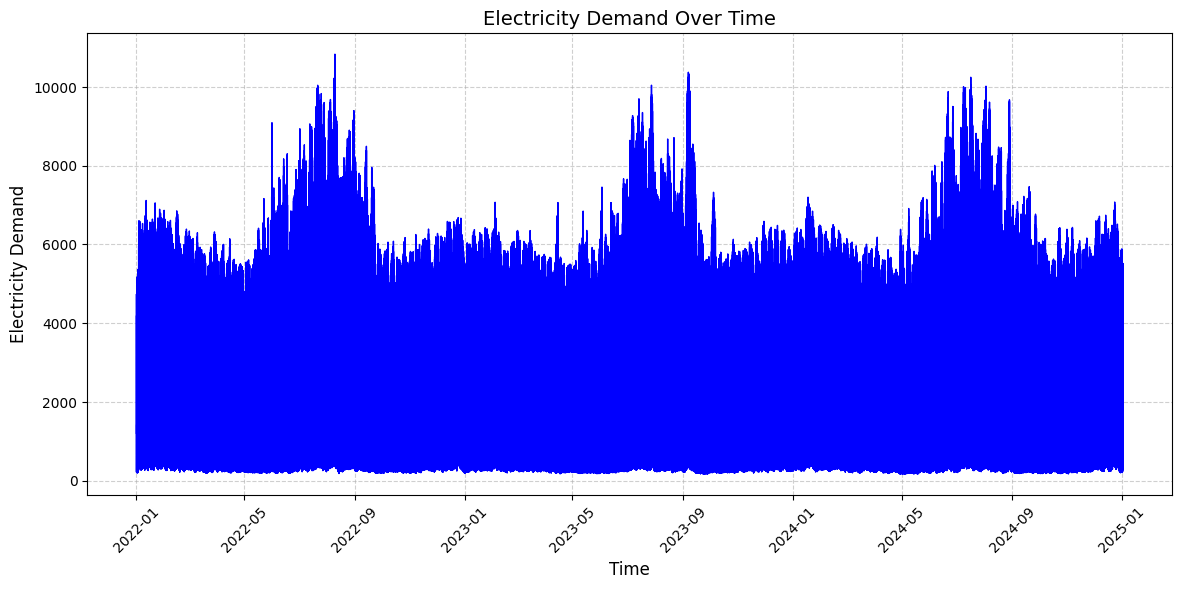

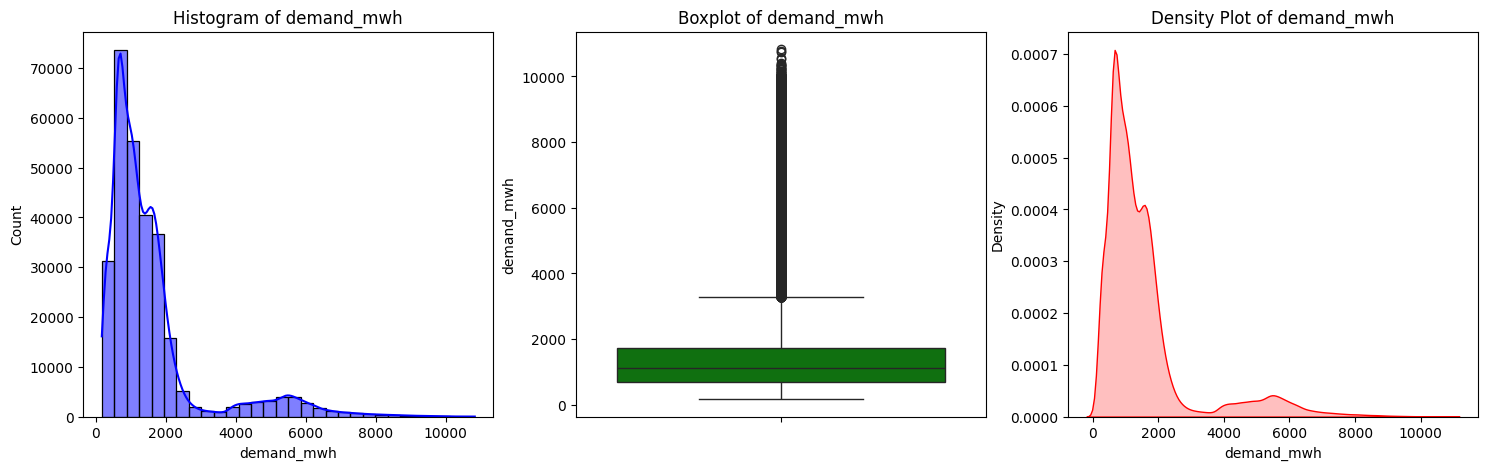


🔹 Statistical Summary for demand_mwh:

count    289531.000000
mean       1556.937606
std        1455.568629
min         168.000000
25%         696.000000
50%        1120.000000
75%        1725.000000
max       10830.000000
Name: demand_mwh, dtype: float64
Skewness: 2.4043887162732576
Kurtosis: 5.927579822911148

--------------------------------------------------


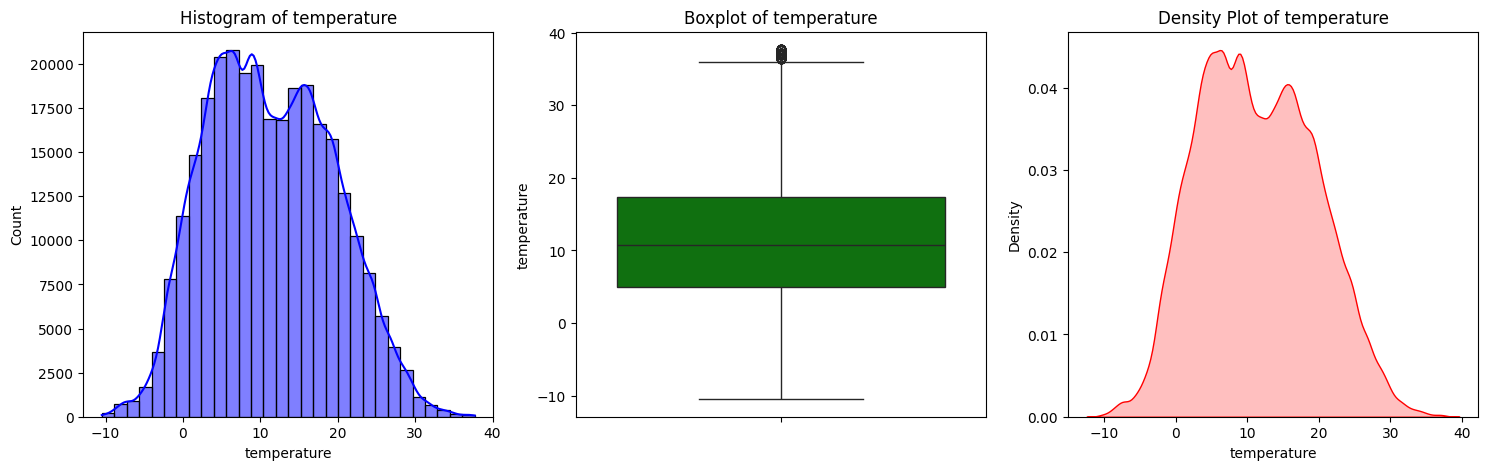


🔹 Statistical Summary for temperature:

count    289531.000000
mean         11.346059
std           8.095719
min         -10.491500
25%           5.008500
50%          10.808500
75%          17.408500
max          37.708500
Name: temperature, dtype: float64
Skewness: 0.17975472735212175
Kurtosis: -0.6071541002206962

--------------------------------------------------


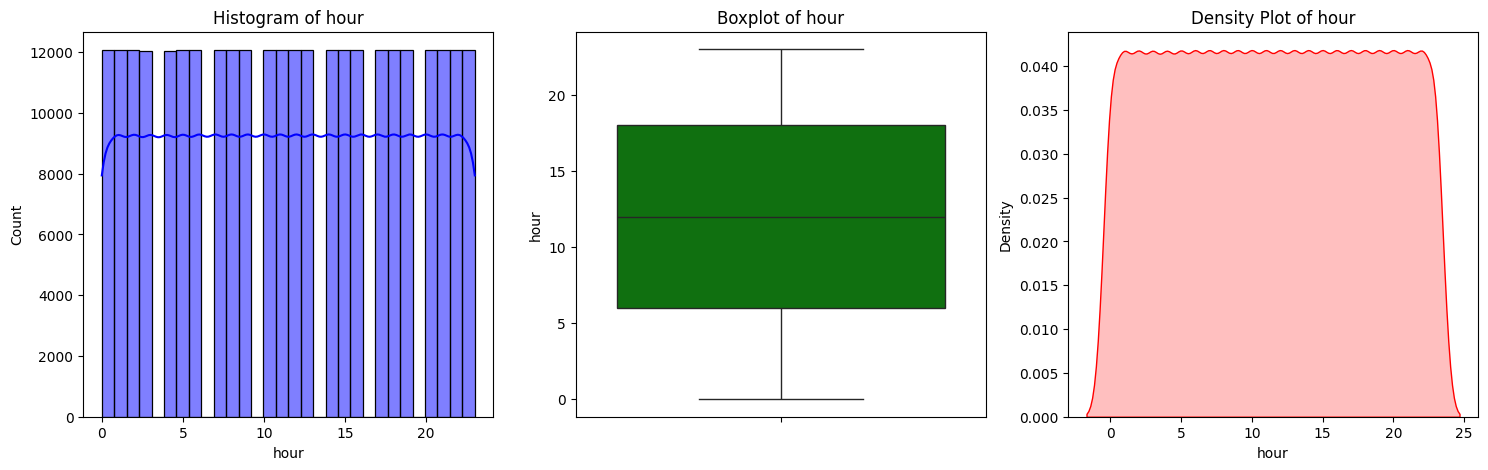


🔹 Statistical Summary for hour:

count    289531.000000
mean         11.502223
std           6.921747
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          23.000000
Name: hour, dtype: float64
Skewness: -0.00046360804247514456
Kurtosis: -1.2038709206037737

--------------------------------------------------


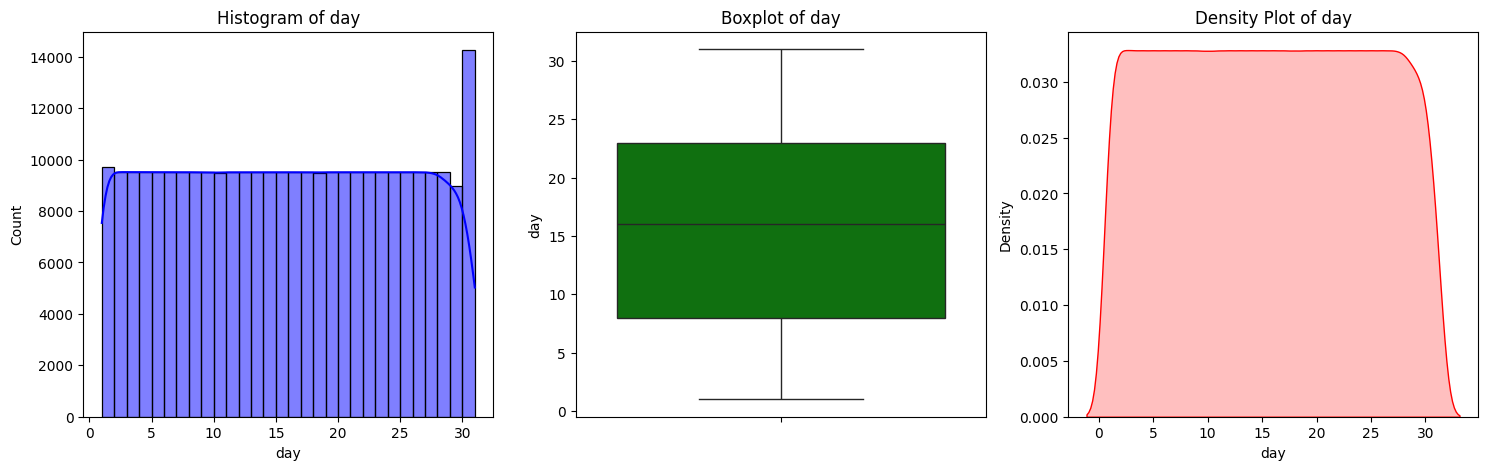


🔹 Statistical Summary for day:

count    289531.000000
mean         15.721857
std           8.807689
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: day, dtype: float64
Skewness: 0.0066659479749006795
Kurtosis: -1.1947627911996819

--------------------------------------------------


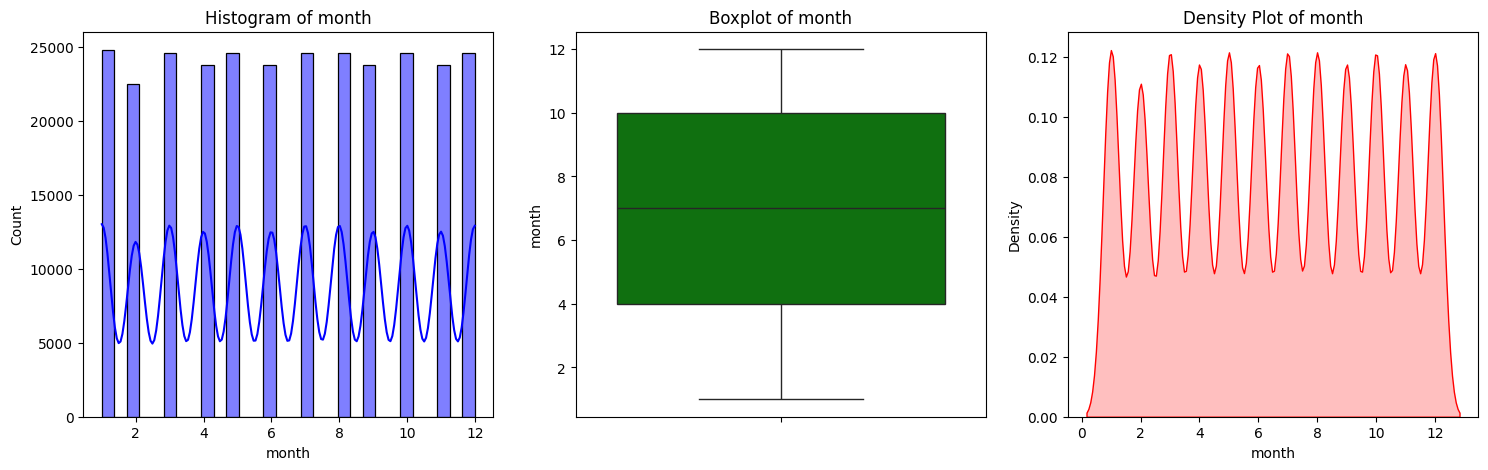


🔹 Statistical Summary for month:

count    289531.000000
mean          6.517648
std           3.450933
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64
Skewness: -0.0082259912991205
Kurtosis: -1.208967106110422

--------------------------------------------------


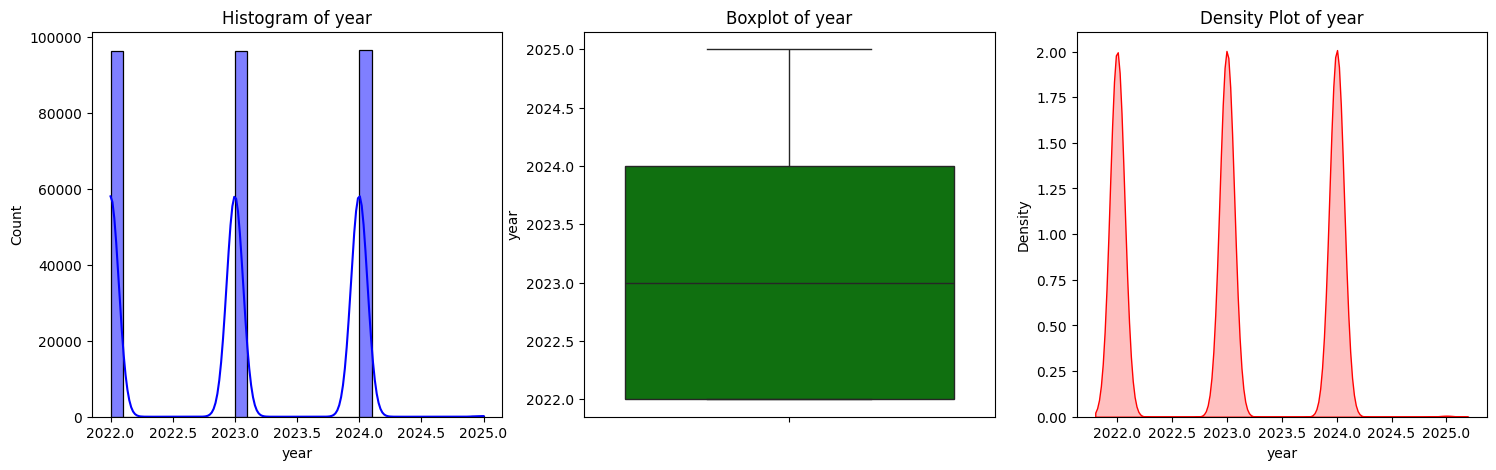


🔹 Statistical Summary for year:

count    289531.000000
mean       2023.002887
std           0.818553
min        2022.000000
25%        2022.000000
50%        2023.000000
75%        2024.000000
max        2025.000000
Name: year, dtype: float64
Skewness: 0.005073054080100816
Kurtosis: -1.4822670264756326

--------------------------------------------------


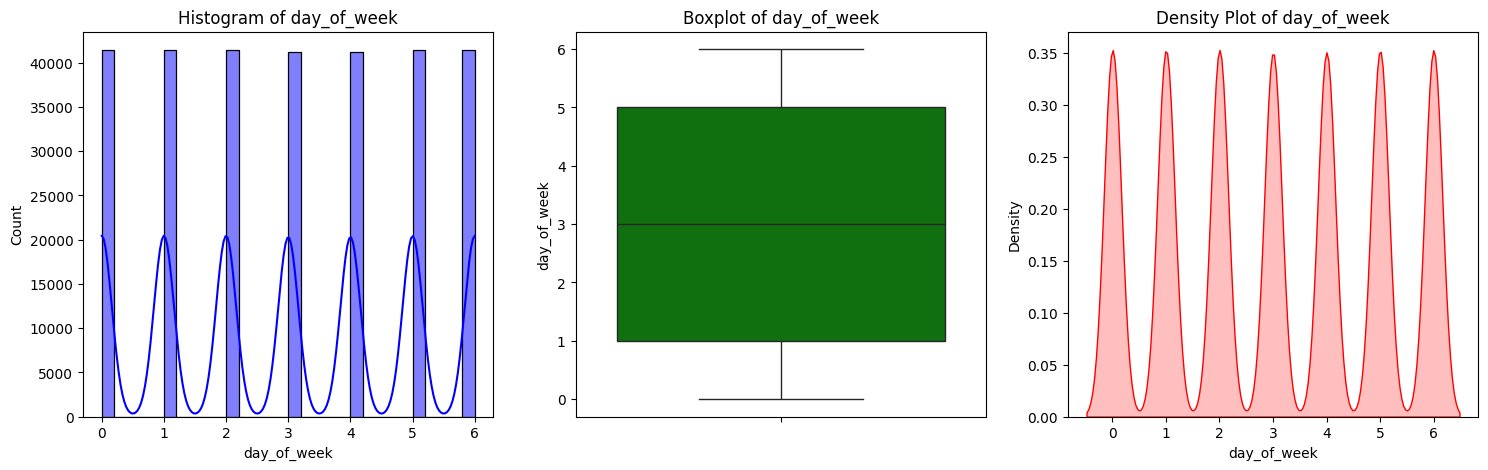


🔹 Statistical Summary for day_of_week:

count    289531.000000
mean          2.998708
std           2.001674
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: day_of_week, dtype: float64
Skewness: 0.001632828515679579
Kurtosis: -1.2524354837870715

--------------------------------------------------


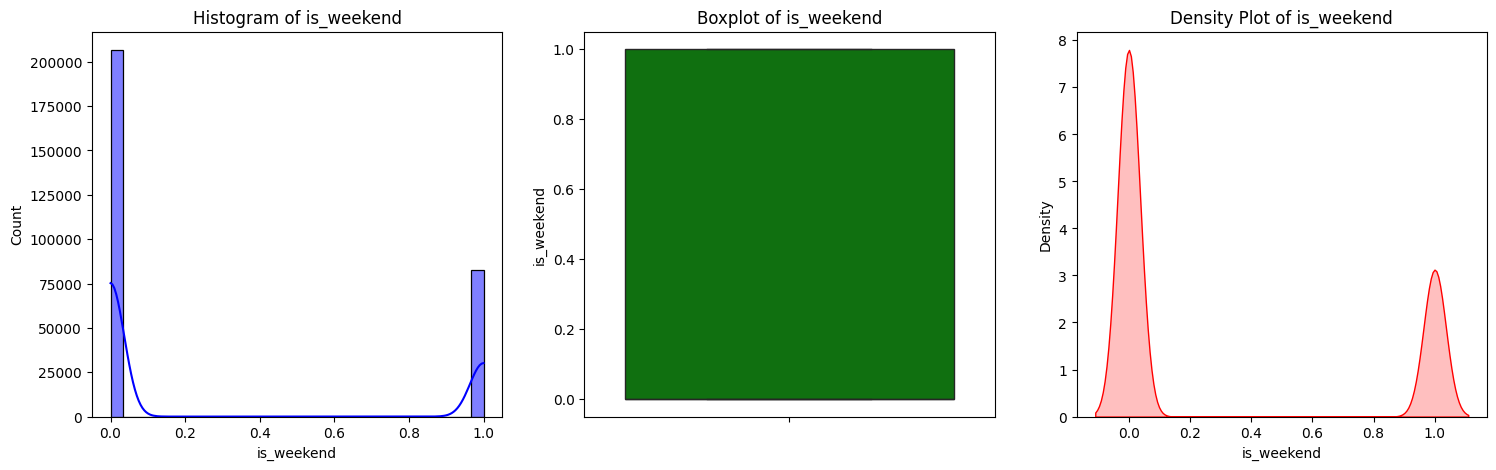


🔹 Statistical Summary for is_weekend:

count    289531.000000
mean          0.286121
std           0.451948
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_weekend, dtype: float64
Skewness: 0.9464819917733677
Kurtosis: -1.1041794666625326

--------------------------------------------------


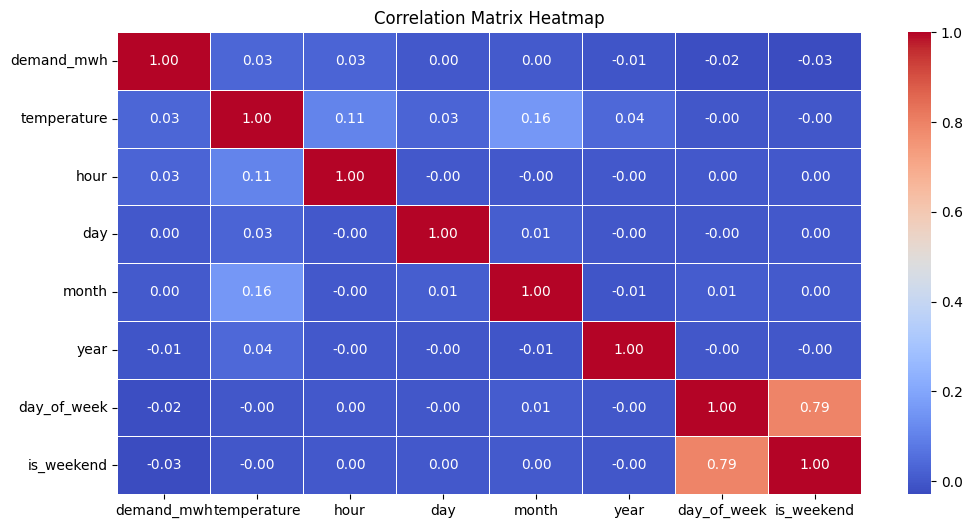


🔹 Highly Correlated Feature Pairs (|correlation| > 0.75):
is_weekend ↔ day_of_week | Correlation: 0.79


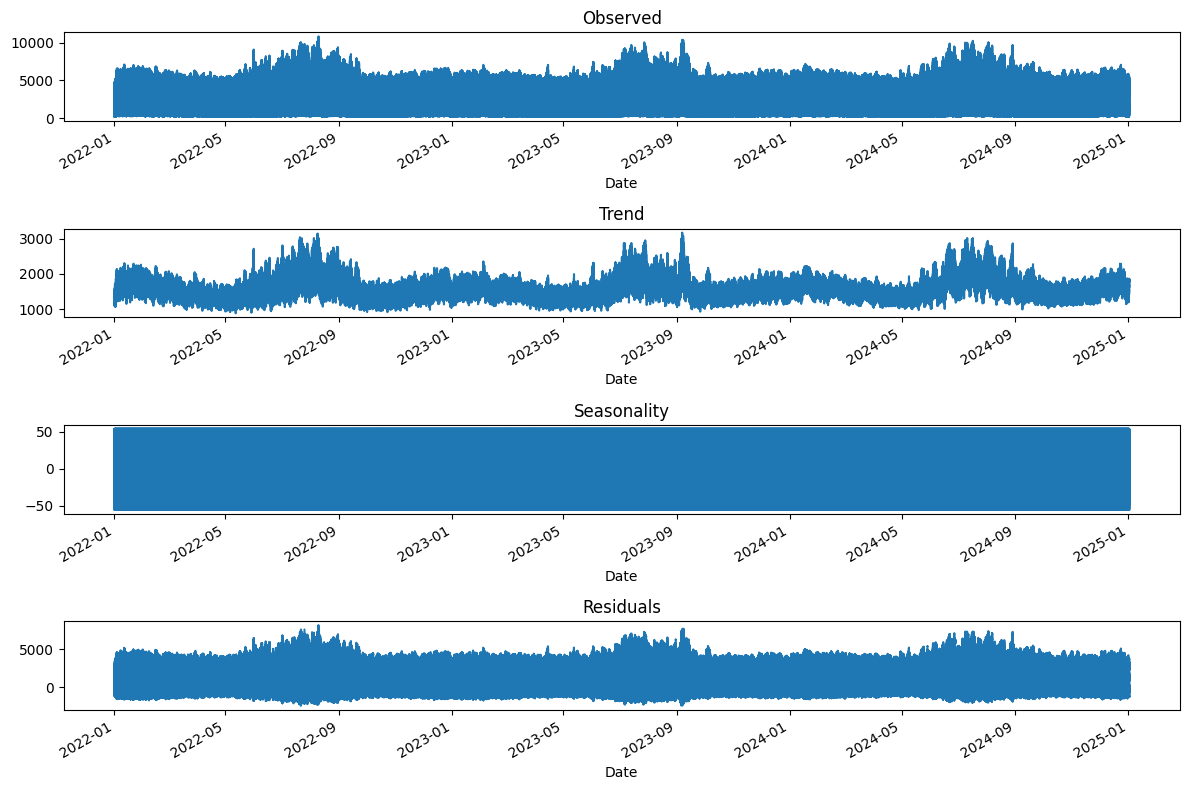


📉 Augmented Dickey-Fuller Test Results:
Test Statistic             -36.493344
p-value                      0.000000
# Lags Used                 89.000000
# Observations Used     289441.000000
Critical Value (1%)         -3.430373
Critical Value (5%)         -2.861550
Critical Value (10%)        -2.566775
dtype: float64

✅ The time series is stationary (p-value < 0.05).
IQR Outliers (demand_mwh): 28496
Z-score Outliers (demand_mwh): 8287
IQR Outliers (temperature): 121
Z-score Outliers (temperature): 132


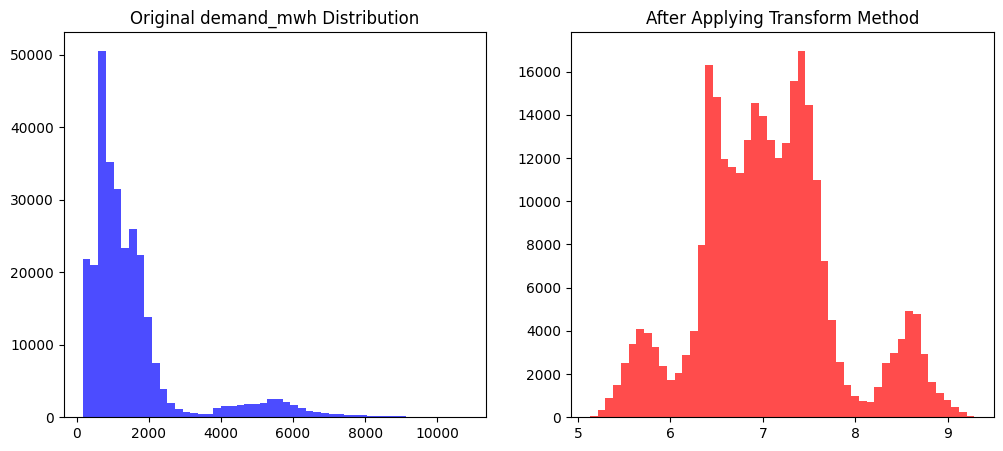

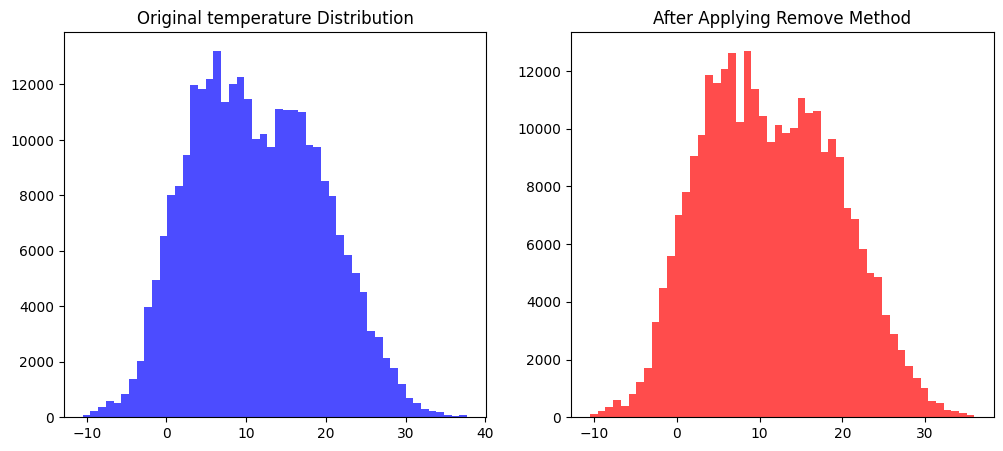

Model Performance Metrics:
MSE: 0.99
RMSE: 0.99
R² Score: 0.02


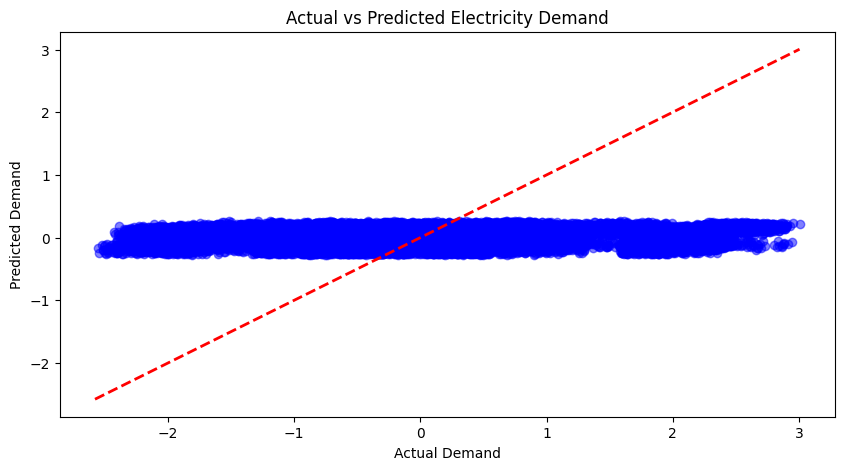

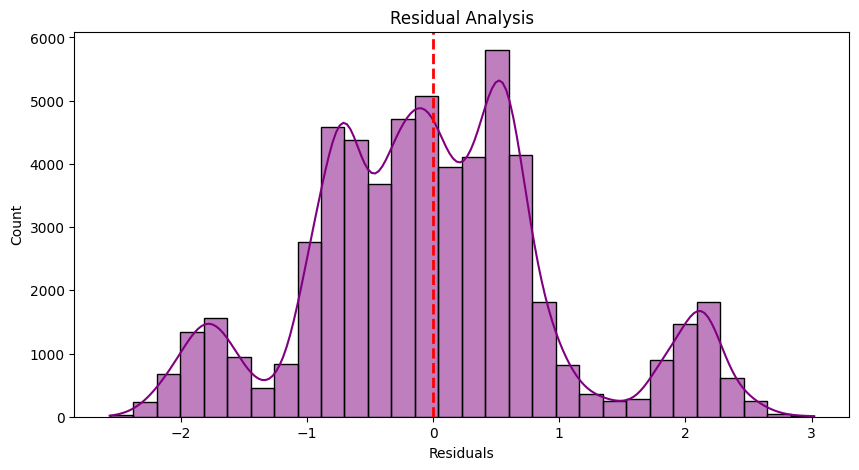

In [18]:
import warnings
warnings.filterwarnings('ignore')

if __name__ == "__main__":

    # Data Loading
    raw_df = merge_data("raw")
    raw_df.to_csv("raw_merged_data.csv", index=False)

    # Data Processing
    processed_df = process_data(raw_df)
    processed_df.to_csv("processed_data.csv", index=False)

    # EDA
    perform_eda(processed_df)

    # Outlier Detection
    cleaned_df = outliers(processed_df)
    cleaned_df.to_csv("cleaned_data.csv", index=False)

    # Normalization
    normalized_df = normalize_data(cleaned_df)
    normalized_df.to_csv("normalized_data.csv", index=False)

    # Regression Model
    model, predictions = regression_model(normalized_df, target="demand_mwh", time_column="datetime")